In [1]:
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import time

import datasets.mvtec as mvtec

from feature_extraction import Resnet18Features, WideResnet50Features
# from distribution_fitting import getMeanCov
# from distance_calculation import calculateScoreMaps, calculateImageScores
# from padim_utils import saveFeatures, loadFeatures
from __init__ import AnomalyDetector, imageAnomalyDetection


In [29]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [30]:
features_model = Resnet18Features(device)
# features_model = WideResnet50Features(device)

In [31]:
tic = time.perf_counter()
mean = torch.load('./distributions/up_mean_test.pkl')
cov_inv = torch.load('./distributions/up_cov_inv_test.pkl')
print(time.perf_counter()-tic)


0.04611262300750241


In [47]:
from utils import toBatch#, getBatchVisImage, calculateScore
from visualization import getBatchVisImage
from feature_extraction import extractEmbeddingVectors, getIndices
from distance_calculation import calculateScoreMaps, calculateImageScores

class AnomalyDetector:
    
    def __init__(self, features_model, mean, cov_inv, device):
        
        self.device = device
        self.features_model = features_model
        self.mean = mean
        self.cov_inv = cov_inv
        
    
    def __call__(self, images, thresh=6):
        tic = time.perf_counter()
        batch = toBatch(images, self.device)
        print('toBatch',time.perf_counter()-tic)
#         print(batch.device)
        tic = time.perf_counter()
        embedding_vectors = extractEmbeddingVectors(self.features_model, batch, self.device)
        idx = getIndices(100, 448, self.device)  
#         idx = getIndices(400, 1792, device)  
        embedding_vectors = torch.index_select(embedding_vectors, 1, idx)
        print('extractEmbeddingVectors',time.perf_counter()-tic)


        tic = time.perf_counter()
        score_maps = calculateScoreMaps(self.mean, self.cov_inv, embedding_vectors)
        score_maps = score_maps.cpu().numpy()
        image_max_values, image_scores = calculateImageScores(score_maps, thresh)#.cpu().numpy() 
        print('calculateScoreMaps',time.perf_counter()-tic)

        tic = time.perf_counter()
        image = getBatchVisImage(images, list(score_maps), thresh, image_scores)#.numpy()
        print('getBatchVisImage',time.perf_counter()-tic)
        
        
        print(image_max_values)
        
        return image_scores, image

In [48]:
ad = AnomalyDetector(features_model, mean, cov_inv, device)

In [49]:
import cv2
paths = [
    '../data/aligned_pucks/defect_up/1622451238634_right_0_up.png', 
    '../data/aligned_pucks/defect_up/1622451238634_right_1_up.png', 
    '../data/aligned_pucks/defect_up/1622451238634_right_2_up.png', 
    '../data/aligned_pucks/defect_up/1622451238634_right_3_up.png', 
    '../data/aligned_pucks/defect_up/1622451238634_right_4_up.png', 
]
images = []
for path in paths:
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    images.append(im)

In [50]:
tic = time.perf_counter()
img_scores, image = ad(images , 10)
print()
print(time.perf_counter()-tic)


toBatch 0.05026587098836899
extractEmbeddingVectors 0.17601326503790915
calculateScoreMaps 1.630726459028665
getBatchVisImage 0.15647913701832294
[ 5.914722   6.2025585 19.700207   5.5565777 26.373474 ]

2.0184447100036778


In [51]:
print(img_scores)

[1, 1, 0, 1, 0]


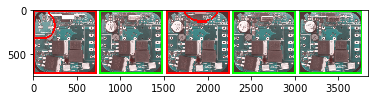

In [52]:
plt.imshow(image)
plt.show()

In [13]:
tic = time.perf_counter()
img_scores, image = imageAnomalyDetection(images[:2])
print(time.perf_counter()-tic)


[5.914722  6.2025585]
1.1034890430164523


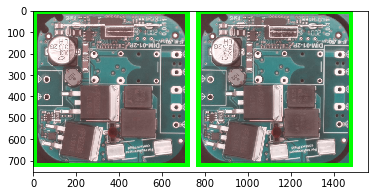

In [14]:
plt.imshow(image)
plt.show()